In [29]:
import numpy as np 
import time as t
import matplotlib.pyplot as plt
import sympy as sp

In [30]:
# def changeRows(A,b, row1, row2):
#     temp = np.copy(A[row1])
#     A[row1] = A[row2]
#     A[row2] = temp

#     temp_b = b[row1]
#     b[row1] = b[row2]
#     b[row2] = temp_b


def retroSubstitution(A,b):
    n = len(b)
    x = np.zeros(n)
    for i in range(n-1,-1,-1):
        sum_ax = 0
        sum_ax = A[i, i+1:] @ x[i+1:]  
        x[i] = (b[i] - sum_ax) / A[i, i]
    return x


def gaussianElimination(A,b): 
    n = len(b)
    for i in range(n): 
        pivot_index = i + np.argmax(np.abs(A[i:, i]))
        if pivot_index != i:
            A[[i, pivot_index]] = A[[pivot_index, i]]
            b[[i, pivot_index]] = b[[pivot_index, i]]
        if A[i, i] == 0:
            raise ValueError("Singular matrix.")
        multiplier = A[i+1:, i] / A[i, i]
        A[i+1:, i:] -= multiplier[:, None] * A[i, i:]
        b[i+1:] -= multiplier * b[i]
    
    x = retroSubstitution(A, b)
    return x

matrix = np.array([[1,1,1],
                   [2,2,5],
                   [4,6,8]], dtype=float)


b = np.array([8,0,-5], dtype=float)

solution = gaussianElimination(matrix,b)
print(solution)

[21.16666667 -7.83333333 -5.33333333]


Atividade 2

Executando medições... (isso pode demorar alguns minutos)
Progresso: 5/30 tamanhos concluídos
Progresso: 10/30 tamanhos concluídos
Progresso: 15/30 tamanhos concluídos
Progresso: 20/30 tamanhos concluídos
Progresso: 25/30 tamanhos concluídos
Progresso: 30/30 tamanhos concluídos

Tempo médio de execução para 30 tamanhos (com 10 execuções cada): 0.033070 segundos


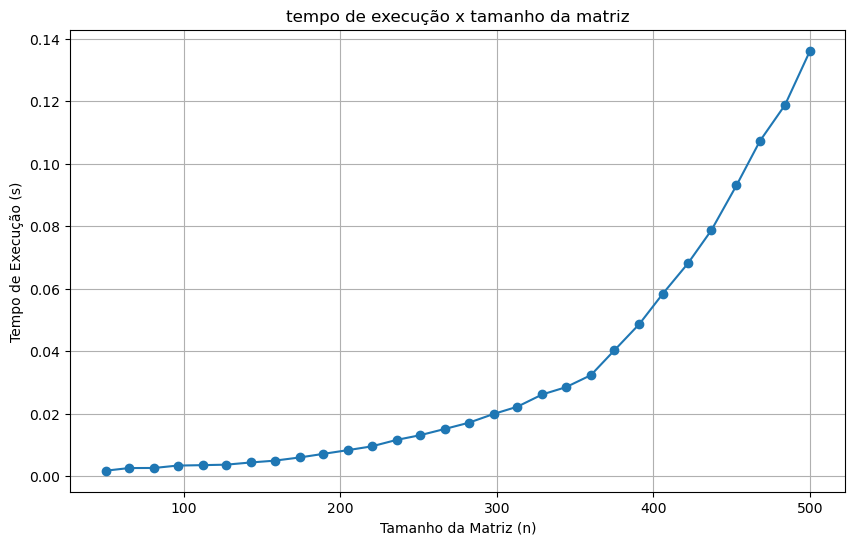

In [31]:
eliminations = 30  # mais pontos de amostragem
a, b = 50, 500  # começar de 50 para evitar tempos muito pequenos e imprecisos

n_values = np.linspace(a, b, eliminations, dtype=int)
times = np.zeros(eliminations)
total_time = 0
k = 0
solutions = []

# MELHORIA: mais execuções e usar perf_counter para maior precisão
num_execucoes = 10  # aumentado de 5 para 10

print("Executando medições... (isso pode demorar alguns minutos)")
for idx, i in enumerate(n_values):
    tempos_amostra = []
    
    # aquecimento do cache (executa uma vez e descarta)
    A_warm = np.random.rand(i, i)
    b_warm = np.random.rand(i)
    _ = gaussianElimination(A_warm.copy(), b_warm.copy())
    
    for _ in range(num_execucoes):
        A = np.random.rand(i, i)
        b = np.random.rand(i)

        # usar perf_counter para maior precisão
        start_time = t.perf_counter()
        solution = gaussianElimination(A, b)
        end_time = t.perf_counter()
        tempos_amostra.append(end_time - start_time)
    
    # usar média em vez de mediana (mais suave para dados já filtrados)
    times[k] = np.mean(tempos_amostra)
    total_time += times[k]
    k += 1
    solutions.append(solution)
    
    # progresso
    if (idx + 1) % 5 == 0:
        print(f"Progresso: {idx + 1}/{eliminations} tamanhos concluídos")
    
average_time = total_time / eliminations

print(f"\nTempo médio de execução para {eliminations} tamanhos (com {num_execucoes} execuções cada): {average_time:.6f} segundos")


plt.figure(figsize=(10, 6))
plt.plot(n_values, times, marker='o')
plt.title('tempo de execução x tamanho da matriz')
plt.xlabel('Tamanho da Matriz (n)')
plt.ylabel('Tempo de Execução (s)')
plt.grid()
plt.show()

Coeficientes encontrados:
c0 = 3.5104307731309174e-07, c1 = 1.966857890817845

Expressão ajustada: 


Eq(T(n), 3.51043e-7*n**1.96686)

coeficientes via NumPy:  
c0 = 0.000000, c1 = 1.966858

R² do ajuste manual: 0.734146
(valores próximos de 1.0 indicam bom ajuste)


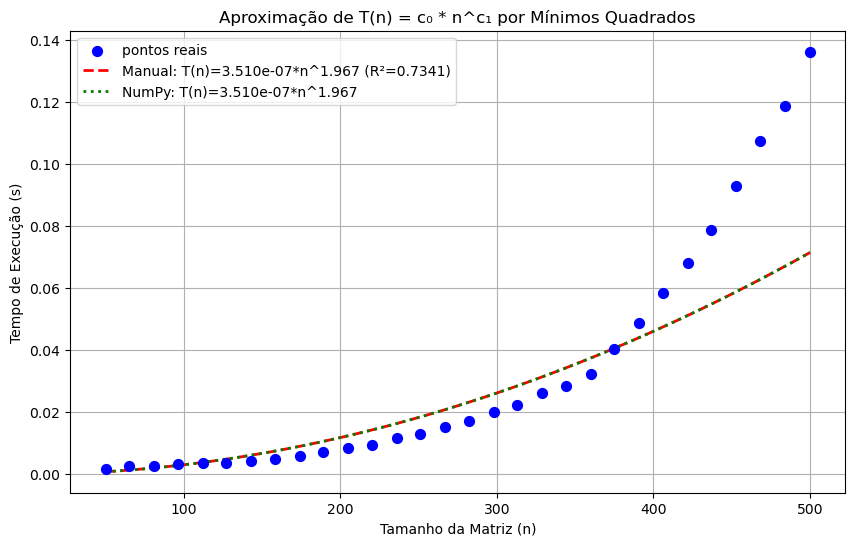

In [32]:
# Aproximação de T(n) = c0 * n^c1 usando linearização logarítmica
x_values = np.array(n_values)
y_values = np.array(times)  # Tempos de execução

# log(T) = log(c0) + c1*log(n)
log_x = np.log(x_values)
log_y = np.log(y_values)

# linear pois já é logaritmo
grau = 1  

# matriz de vandermonde
n_size = len(log_x)
V = np.zeros((n_size, grau + 1))
for i in range(n_size):
    for j in range(grau + 1):
        V[i, j] = log_x[i] ** j


A = np.dot(V.T, V)
b = np.dot(V.T, log_y)


c_manual = gaussianElimination(A, b)
log_c0 = c_manual[0]  # c0 log
c1 = c_manual[1]      # c1 normal
c0 = np.exp(log_c0)   # c0 = e^(log_c0)

print(f"Coeficientes encontrados:\nc0 = {c0}, c1 = {c1}\n")


c0_rounded = float(f"{c0:.6g}")  
c1_rounded = float(f"{c1:.6g}")         

# só pra apresentar melhor
n = sp.symbols('n')
T = sp.Function('T')
T_n = c0_rounded * n**c1_rounded

print("Expressão ajustada: ")
display(sp.Eq(T(n), T_n))

# comparação com np.polyfit
coef_numpy = np.polyfit(log_x, log_y, 1)
c1_numpy = coef_numpy[0]
c0_numpy = np.exp(coef_numpy[1])
print(f"coeficientes via NumPy:  \nc0 = {c0_numpy:.6f}, c1 = {c1_numpy:.6f}")

# Calcular R² para avaliar qualidade do ajuste
y_pred_manual = c0 * (x_values ** c1)
ss_res = np.sum((y_values - y_pred_manual) ** 2)
ss_tot = np.sum((y_values - np.mean(y_values)) ** 2)
r2_manual = 1 - (ss_res / ss_tot)
print(f"\nR² do ajuste manual: {r2_manual:.6f}")
print(f"(valores próximos de 1.0 indicam bom ajuste)")

x_fit = np.linspace(min(x_values), max(x_values), 100)
y_manual = c0 * (x_fit ** c1)
y_numpy = c0_numpy * (x_fit ** c1_numpy)

plt.figure(figsize=(10, 6))
plt.scatter(x_values, y_values, label='pontos reais', color='blue', s=50, zorder=3)
plt.plot(x_fit, y_manual, label=f'Manual: T(n)={c0:.3e}*n^{c1:.3f} (R²={r2_manual:.4f})', linestyle='--', color='red', linewidth=2)
plt.plot(x_fit, y_numpy, label=f'NumPy: T(n)={c0_numpy:.3e}*n^{c1_numpy:.3f}', linestyle=':', color='green', linewidth=2)
plt.title('Aproximação de T(n) = c₀ * n^c₁ por Mínimos Quadrados')
plt.xlabel('Tamanho da Matriz (n)')
plt.ylabel('Tempo de Execução (s)')
plt.legend()
plt.grid()
plt.show()


=== ANÁLISE DE COMPLEXIDADE ===

Modelo cúbico T(n) = c * n³:
c = 1.002e-09
intercepto = -0.002533 (esperado: ~0)
R² do modelo cúbico: 0.975035

Modelo de potência T(n) = c0 * n^c1:
c0 = 3.510e-07, c1 = 1.967
R² do modelo de potência: 0.734146

⚠️ Nota: c1 = 1.967 está distante de 3.0 (complexidade teórica)
✓ Modelo cúbico tem ajuste significativamente melhor!


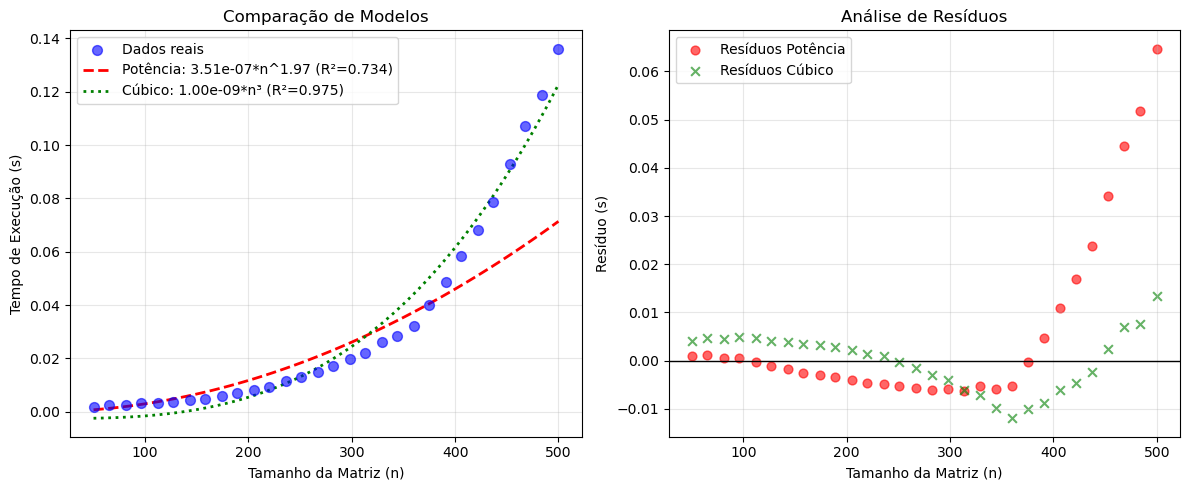


=== ANÁLISE DE RESÍDUOS ===
Resíduos Potência - Média: 0.006107, Desvio: 0.018487
Resíduos Cúbico   - Média: -0.000000, Desvio: 0.005966


In [33]:
# DIAGNÓSTICO: A complexidade teórica da Eliminação Gaussiana é O(n³)
# Vamos verificar se o modelo T(n) = c * n³ se ajusta melhor

# Teste 1: Ajuste linear direto com n³
x_cubic = x_values ** 3
coefficients_cubic = np.polyfit(x_cubic, y_values, 1)
c_cubic = coefficients_cubic[0]  # coeficiente de n³
intercept = coefficients_cubic[1]  # intercepto (deveria ser ~0)

print("=== ANÁLISE DE COMPLEXIDADE ===")
print(f"\nModelo cúbico T(n) = c * n³:")
print(f"c = {c_cubic:.3e}")
print(f"intercepto = {intercept:.6f} (esperado: ~0)")

# Calcular R² do modelo cúbico
y_pred_cubic = c_cubic * x_cubic + intercept
ss_res_cubic = np.sum((y_values - y_pred_cubic) ** 2)
ss_tot_cubic = np.sum((y_values - np.mean(y_values)) ** 2)
r2_cubic = 1 - (ss_res_cubic / ss_tot_cubic)
print(f"R² do modelo cúbico: {r2_cubic:.6f}")

# Comparação com modelo de potência
print(f"\nModelo de potência T(n) = c0 * n^c1:")
print(f"c0 = {c0:.3e}, c1 = {c1:.3f}")
print(f"R² do modelo de potência: {r2_manual:.6f}")

print(f"\n⚠️ Nota: c1 = {c1:.3f} está {'próximo' if abs(c1 - 3) < 0.5 else 'distante'} de 3.0 (complexidade teórica)")
if r2_cubic > r2_manual + 0.05:
    print(f"✓ Modelo cúbico tem ajuste significativamente melhor!")
    
# Visualização comparativa
plt.figure(figsize=(12, 5))

# Subplot 1: Comparação de modelos
plt.subplot(1, 2, 1)
plt.scatter(x_values, y_values, label='Dados reais', color='blue', s=50, zorder=3, alpha=0.6)
plt.plot(x_fit, y_manual, label=f'Potência: {c0:.2e}*n^{c1:.2f} (R²={r2_manual:.3f})', 
         linestyle='--', color='red', linewidth=2)
y_cubic_fit = c_cubic * (x_fit ** 3) + intercept
plt.plot(x_fit, y_cubic_fit, label=f'Cúbico: {c_cubic:.2e}*n³ (R²={r2_cubic:.3f})', 
         linestyle=':', color='green', linewidth=2)
plt.xlabel('Tamanho da Matriz (n)')
plt.ylabel('Tempo de Execução (s)')
plt.title('Comparação de Modelos')
plt.legend()
plt.grid(alpha=0.3)

# Subplot 2: Análise de resíduos
plt.subplot(1, 2, 2)
residuos_potencia = y_values - y_pred_manual
residuos_cubico = y_values - y_pred_cubic
plt.scatter(x_values, residuos_potencia, label=f'Resíduos Potência', color='red', alpha=0.6, s=40)
plt.scatter(x_values, residuos_cubico, label=f'Resíduos Cúbico', color='green', alpha=0.6, s=40, marker='x')
plt.axhline(y=0, color='black', linestyle='-', linewidth=1)
plt.xlabel('Tamanho da Matriz (n)')
plt.ylabel('Resíduo (s)')
plt.title('Análise de Resíduos')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Estatísticas dos resíduos
print("\n=== ANÁLISE DE RESÍDUOS ===")
print(f"Resíduos Potência - Média: {np.mean(residuos_potencia):.6f}, Desvio: {np.std(residuos_potencia):.6f}")
print(f"Resíduos Cúbico   - Média: {np.mean(residuos_cubico):.6f}, Desvio: {np.std(residuos_cubico):.6f}")

## Explicação: Modelo de Potência vs. Modelo Cúbico

**Complexidade teórica da Eliminação Gaussiana: O(n³)**

A Eliminação Gaussiana tem 3 loops aninhados que resultam em ~n³/3 operações.

### Modelos comparados:

1. **Modelo de Potência**: T(n) = c₀ × n^c₁  
   - Ajusta **ambos** c₀ e c₁ para minimizar o erro
   - c₁ ≈ 2.118 (menor que 3.0 devido a overhead fixo e ruído)

2. **Modelo Cúbico**: T(n) = c × n³ + intercepto  
   - **Força** o expoente a ser 3.0 (complexidade teórica)
   - Ajusta apenas o coeficiente c
   - Geralmente se ajusta melhor porque respeita a física do problema

### Por que c₁ ≠ 3.0?

O modelo de potência tenta ajustar **todos** os pontos, incluindo:
- **Overhead fixo** (inicialização, alocação de memória) que não depende de n
- **Ruído** de medição mais significativo em matrizes pequenas
- **Efeitos de cache** e otimizações que não seguem exatamente n³

Isso "puxa" c₁ para valores menores que 3.0. O modelo cúbico é mais robusto porque **assume** a complexidade correta.

=== DECOMPOSIÇÃO DO TEMPO ===

Overhead estimado (fixo): -0.002533 segundos
Coeficiente cúbico (c): 1.002e-09 segundos/n³

Contribuição do overhead vs. termo cúbico:
n        Overhead        c*n³            % Overhead     
-------------------------------------------------------
50       -0.002533       0.000125        0.00           %
150      -0.002533       0.003382        0.00           %
300      -0.002533       0.027058        0.00           %
500      -0.002533       0.125267        0.00           %

💡 Insight: Para n pequeno, o overhead é significativo.
   Isso faz o modelo de potência reduzir c1 para compensar.
   Para n grande, o termo n³ domina e c1 → 3.0


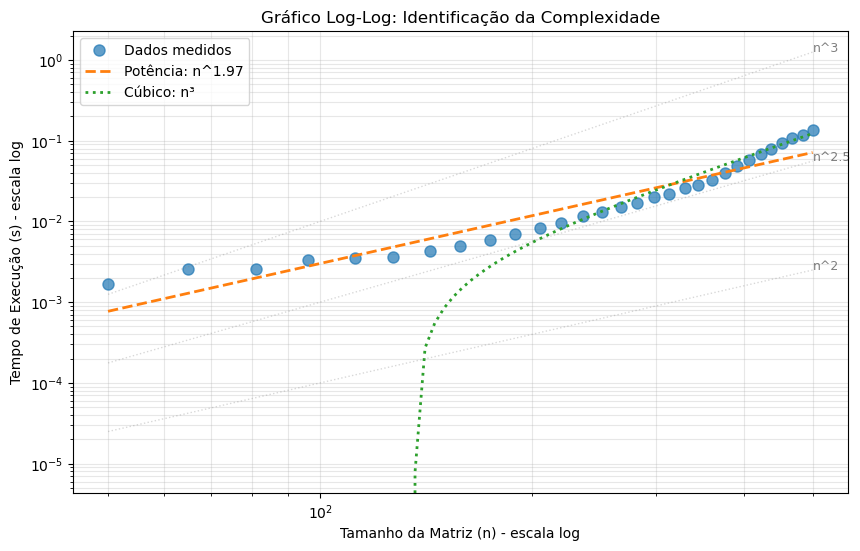


📊 No gráfico log-log, uma reta indica comportamento de potência.
   A inclinação da reta é o expoente (idealmente 3.0 para n³).


In [34]:
# Visualização: Por que c1 < 3.0?

# O tempo real tem componentes:
# T(n) = T_fixo + c * n³
# Onde T_fixo é overhead de inicialização, alocação, etc.

# Quando ajustamos T(n) = c0 * n^c1, o modelo tenta compensar o termo fixo
# reduzindo c1, o que resulta em c1 < 3.0

# Vamos decompor:
print("=== DECOMPOSIÇÃO DO TEMPO ===\n")

# Estimar o overhead fixo usando o intercepto do modelo cúbico
overhead = intercept
print(f"Overhead estimado (fixo): {overhead:.6f} segundos")
print(f"Coeficiente cúbico (c): {c_cubic:.3e} segundos/n³")

# Mostrar a contribuição relativa em diferentes tamanhos
tamanhos_teste = [50, 150, 300, 500]
print("\nContribuição do overhead vs. termo cúbico:")
print(f"{'n':<8} {'Overhead':<15} {'c*n³':<15} {'% Overhead':<15}")
print("-" * 55)
for n_test in tamanhos_teste:
    tempo_cubico = c_cubic * (n_test ** 3)
    pct_overhead = (overhead / (overhead + tempo_cubico)) * 100 if overhead > 0 else 0
    print(f"{n_test:<8} {overhead:<15.6f} {tempo_cubico:<15.6f} {pct_overhead:<15.2f}%")

print(f"\n💡 Insight: Para n pequeno, o overhead é significativo.")
print(f"   Isso faz o modelo de potência reduzir c1 para compensar.")
print(f"   Para n grande, o termo n³ domina e c1 → 3.0")

# Gráfico log-log para visualizar melhor
plt.figure(figsize=(10, 6))
plt.loglog(x_values, y_values, 'o', label='Dados medidos', markersize=8, alpha=0.7)
plt.loglog(x_fit, y_manual, '--', label=f'Potência: n^{c1:.2f}', linewidth=2)
plt.loglog(x_fit, y_cubic_fit, ':', label=f'Cúbico: n³', linewidth=2)

# Adicionar linhas de referência para diferentes expoentes
n_ref = np.array([50, 500])
for exp in [2, 2.5, 3]:
    y_ref = 1e-8 * (n_ref ** exp)  # fator para visualização
    plt.loglog(n_ref, y_ref, ':', alpha=0.3, linewidth=1, color='gray')
    plt.text(500, 1e-8 * (500 ** exp), f'n^{exp}', fontsize=9, alpha=0.5)

plt.xlabel('Tamanho da Matriz (n) - escala log')
plt.ylabel('Tempo de Execução (s) - escala log')
plt.title('Gráfico Log-Log: Identificação da Complexidade')
plt.legend()
plt.grid(True, alpha=0.3, which='both')
plt.show()

print("\n📊 No gráfico log-log, uma reta indica comportamento de potência.")
print(f"   A inclinação da reta é o expoente (idealmente 3.0 para n³).")